In [1]:
import numpy as np
import time
from imageio import imread
import matplotlib.pyplot as plt

from scipy.fftpack import fft2, ifft2, fftshift, ifftshift
from scipy.ndimage.filters import convolve
from skimage.draw import circle
from skimage.transform import resize
from functools import partial

(512, 512)


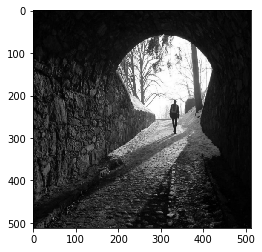

In [2]:
im = imread("../../samples/bridge.jpg", pilmode="L")
im = resize(im, (512, 512), order=1, anti_aliasing=True, mode="reflect") 
im = (im*255).astype(np.uint8)
plt.imshow(im, vmax=255, vmin=0, cmap="gray")
print(im.shape)
plt.show()

# Exercise 4: Filtering in Frequency Domain

The Fourier transformation in the descrete domain is defined as:

$$
\begin{align}
F(u,v)
    &= \sum_{x=0}^{M}\sum_{y=0}^{N}f(x,y) \cdot e^{-2i\pi\cdot\left(\dfrac{u \cdot x}{M} + \dfrac{v \cdot y}{N} \right)} \\
    &= \sum_{x=0}^{M}\sum_{y=0}^{N} \dfrac{f(x,y)}{e^{2i\pi\cdot\left(\dfrac{u \cdot x}{M} + \dfrac{v \cdot y}{N} \right)}} \\
e^{i \cdot \rho \cdot x} 
    &= \mathrm{cos}(\rho \cdot x) + i\cdot \mathrm{sin}(\rho \cdot x)
\end{align}
$$




## Task 4 - Homomorphic Filtering

Implement a functions, that performs homomorphic filtering to an image. Visualize the results and test your implementation for different images!

In [3]:
def normalize(im):
    """
        Small helper function for image renormalization
    """
    im = im.astype(np.float32)
    im -= im.min()
    im /= im.max()
    return im
    

def DFT(im, shift=False):
    if im.dtype == np.uint8:
        im = im.astype(np.float) / 255
    
    I = fft2(im)
    if shift:
        I = fftshift(I)
    
    return I

def iDFT(I, shift=False, norm=False):
    if shift:
        I = ifftshift(I)
    
    im = ifft2(I)
    if norm:
        im = normalize(im.real)
    else:
        im = im.real
        
    return im

In [4]:
def gauss_filter(size, sigma=1):
    """
        creates gaussian kernel with a given size and sigma
    """
    ax = np.arange(-size // 2 + 1., size // 2 + 1.)
    xx, yy = np.meshgrid(ax, ax)

    kernel = np.exp(-(xx**2 + yy**2) / (2. * sigma**2))

    return kernel / kernel.sum()

def homomorphic_filter(im, radius_ratio=0.2, l=0.2):
    log_im = np.log1p(im)
    I = DFT(im, shift=True)
    radius = int(min(im.shape) * radius_ratio)

    # create a low pass filter
    pass_mask = gauss_filter(min(im.shape), radius)
    
    # convert to high pass filter
    pass_mask = 1 - pass_mask
    
    # normalize to [0..1] 
    pass_mask = normalize(pass_mask)
    
    # scale to [l .. 1] ([0 .. 1] -> [0 .. 1-l] -> [l .. 1])
    pass_mask *= 2 - l
    pass_mask += l
    
    res = iDFT(I * pass_mask, shift=True, norm=False)
    
    res = np.expm1(res)
    return normalize(res)

/home/korsch/.anaconda3/envs/chainer4/lib/python3.6/site-packages/scipy/fftpack/basic.py:160: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  z[index] = x


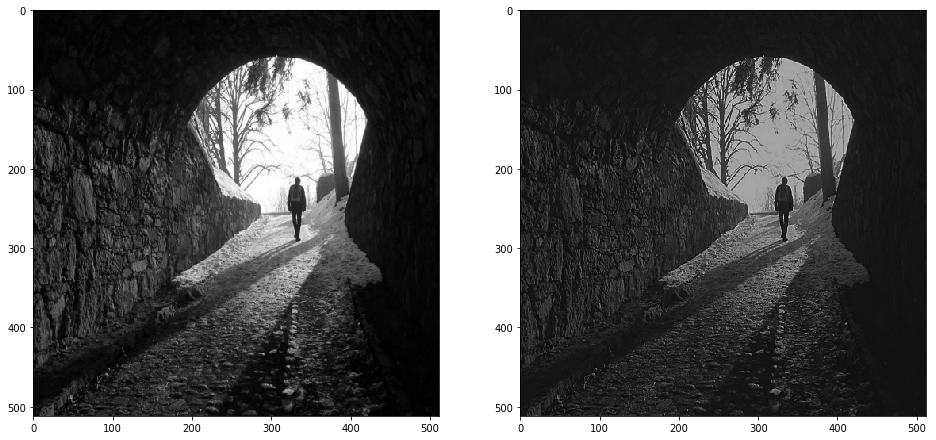

In [5]:
fig, axs = plt.subplots(1, 2, figsize=(16, 9))
# [ax.axis("off") for ax in axs.ravel()]

size = 0.2
im0 = homomorphic_filter(im, size, 0.75)

axs[0].imshow(im, vmin=0, vmax=255, cmap=plt.cm.gray)
axs[1].imshow(im0, cmap=plt.cm.gray)
plt.show()
plt.close()